# Explicit Feedback Neural Recommender Systems

Goals:
- Understand recommender data
- Build different models architectures using Keras
- Retrieve Embeddings and visualize them
- Add metadata information as input to the model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.rsplit('/', 1)[1]
ML_100K_FOLDER = 'ml-100k'

if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall('.')

### Ratings file

Each line contains a rated movie: 
- a user
- an item
- a rating from 1 to 5 stars

In [2]:
import pandas as pd

raw_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                      names=["user_id", "item_id", "rating", "timestamp"])
raw_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Item metadata file

The item metadata file contains metadata like the name of the movie or the date it was released. The movies file contains columns indicating the movie's genres. Let's only load the first five columns of the file with `usecols`.

In [3]:
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')
items.head()

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


Let's write a bit of Python preprocessing code to extract the release year as an integer value:

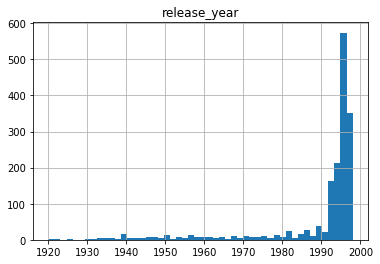

In [4]:
def extract_year(release_date):
    if hasattr(release_date, 'split'):
        components = release_date.split('-')
        if len(components) == 3:
            return int(components[2])
    # Missing value marker
    return 1920


items['release_year'] = items['release_date'].map(extract_year)
items.hist('release_year', bins=50);

Enrich the raw ratings data with the collected items metadata:

In [5]:
all_ratings = pd.merge(items, raw_ratings)

In [6]:
all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


### Data preprocessing

To understand well the distribution of the data, the following statistics are computed:
- the number of users
- the number of items
- the rating distribution
- the popularity of each movie

In [7]:
max_user_id = all_ratings['user_id'].max()
max_user_id

943

In [8]:
max_item_id = all_ratings['item_id'].max()
max_item_id

1682

In [9]:
all_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Let's do a bit more pandas magic compute the popularity of each movie (number of ratings):

In [10]:
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items)
items.nlargest(10, 'popularity')

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year
49,50,583,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977
257,258,509,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),1997
99,100,508,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),1997
180,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997
293,294,485,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),1997
285,286,481,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,1996
287,288,478,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),1996
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
299,300,431,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,1997
120,121,429,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,1996


Enrich the ratings data with the popularity as an additional metadata.

In [11]:
all_ratings = pd.merge(popularity, all_ratings)
all_ratings.head()

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


Later in the analysis we will assume that this popularity does not come from the ratings themselves but from an external metadata, e.g. box office numbers in the month after the release in movie theaters.

Let's split the enriched data in a train / test split to make it possible to do predictive modeling:

In [12]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['rating']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['rating']

# Explicit feedback: supervised ratings prediction

For each pair of (user, item) try to predict the rating the user would give to the item.

This is the classical setup for building recommender systems from offline data with explicit supervision signal. 

## Predictive ratings  as a regression problem

The following code implements the following architecture:

<img src="images/rec_archi_1.svg" style="width: 600px;" />

In [13]:
import tensorflow
from tensorflow.contrib import keras
from keras.layers import Input, Embedding, Flatten, Dense, Dropout
from keras.layers import Dot
from keras.models import Model

/home/elvis/anaconda2/envs/py3k/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

y = Dot(axes=1)([user_vecs, item_vecs])
# y = merge([user_vecs, item_vecs], mode=dot_mode, output_shape=(1,))

model = Model(inputs=[user_id_input, item_id_input], outputs=y)
model.compile(optimizer='adam', loss='mae')

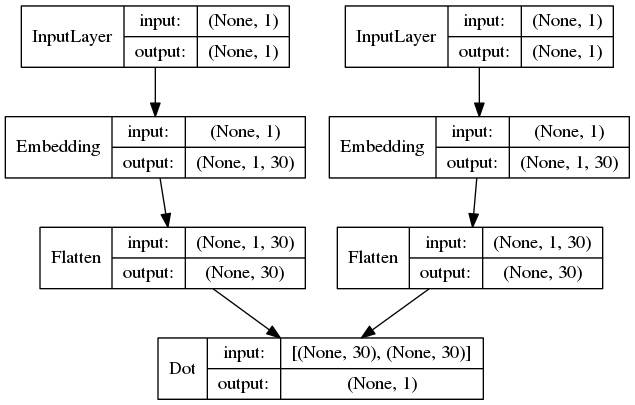

In [21]:
from IPython.display import Image 
utils.plot_model(model, to_file="model.png", show_layer_names=False, show_shapes=True)
Image(filename='model.png')

In [22]:
# Useful for debugging the output shape of model
initial_train_preds = model.predict([user_id_train, item_id_train])
initial_train_preds.shape

(80000, 1)

### Model error

Using `initial_train_preds`, compute the model errors:
- mean absolute error
- mean squared error

Converting a pandas Series to numpy array is usually implicit, but you may use `rating_train.values` to do so explicitely. Be sure to monitor the shapes of each object you deal with by using `object.shape`.

In [30]:
# %load solutions/compute_errors.py
squared_differences = np.square(initial_train_preds[:,0] - rating_train.values)
absolute_differences = np.abs(initial_train_preds[:,0] - rating_train.values)

print("Random init MSE: %0.3f" % np.mean(squared_differences))
print("Random init MAE: %0.3f" % np.mean(absolute_differences))

# You may also use sklearn metrics to do so using scikit-learn:

from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Random init MSE: %0.3f" % mean_squared_error(initial_train_preds, rating_train))
print("Random init MAE: %0.3f" % mean_absolute_error(initial_train_preds, rating_train))


Random init MSE: 13.719
Random init MAE: 3.529
Random init MSE: 13.719
Random init MAE: 3.529


### Monitoring runs

Keras enables to monitor various variables during training. 

`history.history` returned by the `model.fit` function is a dictionary
containing the `'loss'` and validation loss `'val_loss'` after each epoch

In [32]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=6, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/6
72000/72000 [==============================] - 2s 32us/step - loss: 2.9462 - val_loss: 1.3786
Epoch 2/6
72000/72000 [==============================] - 2s 32us/step - loss: 0.9822 - val_loss: 0.8401
Epoch 3/6
72000/72000 [==============================] - 2s 32us/step - loss: 0.7826 - val_loss: 0.7851
Epoch 4/6
72000/72000 [==============================] - 2s 32us/step - loss: 0.7475 - val_loss: 0.7668
Epoch 5/6
72000/72000 [==============================] - 2s 32us/step - loss: 0.7315 - val_loss: 0.7561
Epoch 6/6
72000/72000 [==============================] - 2s 32us/step - loss: 0.7193 - val_loss: 0.7511
CPU times: user 22.7 s, sys: 796 ms, total: 23.5 s
Wall time: 14.1 s


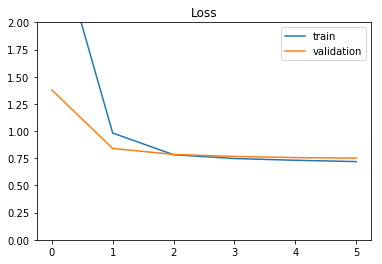

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

**Questions**:

- Why is the train loss higher than the first loss in the first few epochs?
- Why is Keras not computing the train loss on the full training set at the end of each epoch as it does on the validation set?


Now that the model is trained, the model MSE and MAE look nicer:

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.932
Final test MAE: 0.742


In [35]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final train MSE: 0.847
Final train MAE: 0.700


## A Deep recommender model

Using a similar framework as previously, the following deep model described in the course was built (with only two fully connected)

<img src="images/rec_archi_2.svg" style="width: 600px;" />

To build this model we will need a new kind of layer:

In [37]:
from keras.layers import Concatenate


### Exercise

- The following code has **4 errors** that prevent it from working correctly. **Correct them and explain** why they are critical.

In [47]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = Concatenate()([user_vecs, item_vecs])
input_vecs = Dropout(0.5)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)
y = Dense(1)(x)

model = Model(inputs=[user_id_input, item_id_input], outputs=y)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train])

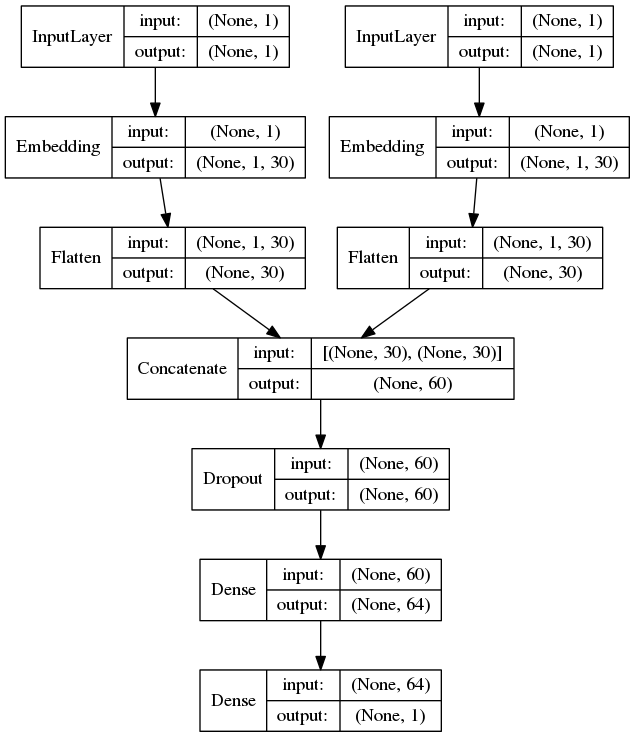

In [48]:
utils.plot_model(model, to_file="model_dl.png", show_layer_names=False, show_shapes=True)
Image(filename='model_dl.png')

In [46]:
# %load solutions/deep_explicit_feedback_recsys.py

In [49]:
%%time
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=5, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/5
72000/72000 [==============================] - 3s 40us/step - loss: 1.0058 - val_loss: 0.7586
Epoch 2/5
72000/72000 [==============================] - 3s 40us/step - loss: 0.7552 - val_loss: 0.7455
Epoch 3/5
72000/72000 [==============================] - 3s 40us/step - loss: 0.7405 - val_loss: 0.7403
Epoch 4/5
72000/72000 [==============================] - 3s 39us/step - loss: 0.7319 - val_loss: 0.7379
Epoch 5/5
72000/72000 [==============================] - 3s 42us/step - loss: 0.7265 - val_loss: 0.7342
CPU times: user 24.8 s, sys: 840 ms, total: 25.7 s
Wall time: 14.8 s


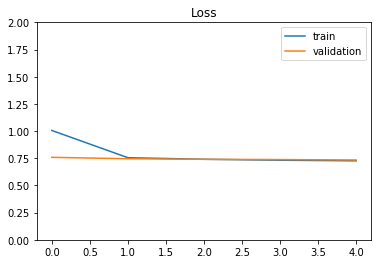

In [50]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [ ]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

In [ ]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

### Home assignment: 
 - Add another layer, compare train/test error
 - What do you notice? 
 - Try adding more dropout and modifying layer sizes: should you increase
   or decrease the number of parameters

### Model Embeddings

- It is possible to retrieve the embeddings by simply using the Keras function `model.get_weights` which returns all the model learnable parameters.
- The weights are returned the same order as they were build in the model
- What is the total number of parameters?

In [53]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(944, 30), (1683, 30), (60, 64), (64,), (64, 1), (1,)]

In [ ]:
# Solution: 
# model.summary()

In [54]:
user_embeddings = weights[0]
item_embeddings = weights[1]
print("First item name from metadata:", items["title"][1])
print("Embedding vector for the first item:")
print(item_embeddings[1])
print("shape:", item_embeddings[1].shape)

First item name from metadata: GoldenEye (1995)
Embedding vector for the first item:
[ 0.09775776 -0.06718309 -0.07533434  0.04955715 -0.03317084 -0.12847055
 -0.05416141  0.03174883  0.04289723  0.10038389  0.08458623  0.0569993
  0.00072331  0.06713373 -0.03869562 -0.00564704  0.03187736 -0.05186514
 -0.06564455 -0.03907751  0.0195974  -0.04887109  0.0746108   0.13319343
  0.05329883 -0.01638749 -0.02676403  0.08301975 -0.02012061  0.03218472]
shape: (30,)


### Finding most similar items
Finding k most similar items to a point in embedding space

- Write in numpy a function to compute the cosine similarity between two points in embedding space
- Write a function which computes the euclidean distance between a point in embedding space and all other points
- Write a most similar function, which returns the k item names with lowest euclidean distance
- Try with a movie index, such as 181 (Return of the Jedi). What do you observe? Don't expect miracles on such a small training set.

Notes:
- you may use `np.linalg.norm` to compute the norm of vector, and you may specify the `axis=`
- the numpy function `np.argsort(...)` enables to compute the sorted indices of a vector
- `items["name"][idxs]` returns the names of the items indexed by array idxs

In [ ]:
EPSILON = 1e-07

def cosine(x, y):
    # TODO: modify function
    return 0.

# Computes euclidean distances between x and all item embeddings
def euclidean_distances(x):
    # TODO: modify function
    return 0.

# Computes top_n most similar items to an idx
def most_similar(idx, top_n=10):
    # TODO: modify function
    idxs = np.array([1,2,3])
    return items["title"][idxs]

most_similar(181)

In [ ]:
# %load solutions/similarity.py

### Visualizing embeddings using TSNE

- we use scikit learn to visualize items embeddings
- Try different perplexities, and visualize user embeddings as well
- What can you conclude ?

In [55]:
from sklearn.manifold import TSNE

item_tsne = TSNE(perplexity=30).fit_transform(item_embeddings)

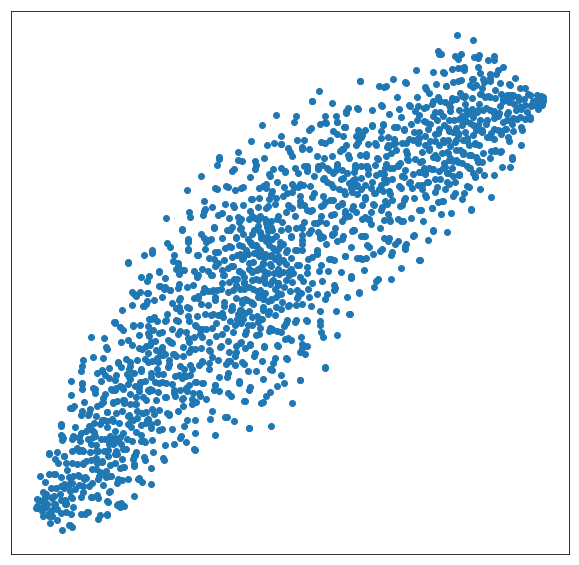

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

Alternatively with [Uniform Manifold Approximation and Projection](https://github.com/lmcinnes/umap):

In [57]:
!pip install umap-learn

    100% |████████████████████████████████| 1.9MB 777kB/s ta 0:00:011
    100% |████████████████████████████████| 14.8MB 87kB/s  eta 0:00:01
  Running setup.py bdist_wheel for umap-learn ... done
  Stored in directory: /home/elvis/.cache/pip/wheels/21/e4/cf/f19e0537fd6eb03a3e6500402eed01357eb935d9aa6e4a7029
Successfully built umap-learn
  Found existing installation: llvmlite 0.18.0
    Uninstalling llvmlite-0.18.0:
      Successfully uninstalled llvmlite-0.18.0
  Found existing installation: numba 0.33.0
    Uninstalling numba-0.33.0:
      Successfully uninstalled numba-0.33.0


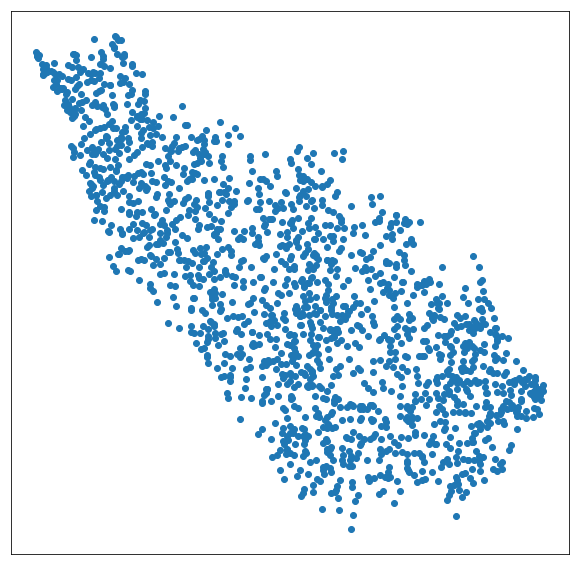

In [58]:
import umap

item_umap = umap.UMAP().fit_transform(item_embeddings)
plt.figure(figsize=(10, 10))
plt.scatter(item_umap[:, 0], item_umap[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

## Using item metadata in the model

Using a similar framework as previously, we will build another deep model that can also leverage additional metadata. The resulting system is therefore an **Hybrid Recommender System** that does both **Collaborative Filtering** and **Content-based recommendations**.

<img src="images/rec_archi_3.svg" style="width: 600px;" />


In [ ]:
from sklearn.preprocessing import QuantileTransformer

meta_columns = ['popularity', 'release_year']

scaler = QuantileTransformer()
item_meta_train = scaler.fit_transform(ratings_train[meta_columns])
item_meta_test = scaler.transform(ratings_test[meta_columns])

In [ ]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
meta_input = Input(shape=[2], name='meta_item')

embedding_size = 32
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)


# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = Concatenate()([user_vecs, item_vecs, meta_input])

x = Dense(64, activation='relu')(input_vecs)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
y = Dense(1)(x)

model = Model(inputs=[user_id_input, item_id_input, meta_input], outputs=y)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train, item_meta_train])

In [ ]:
%%time
history = model.fit([user_id_train, item_id_train, item_meta_train], rating_train,
                    batch_size=64, epochs=15, validation_split=0.1,
                    shuffle=True)

In [ ]:
test_preds = model.predict([user_id_test, item_id_test, item_meta_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

The additional metadata seem to improve the predictive power of the model a bit at least in terms of MAE.


### A recommendation function for a given user

Once the model is trained, the system can be used to recommend a few items for a user, that he/she hasn't already seen:
- we use the `model.predict` to compute the ratings a user would have given to all items
- we build a reco function that sorts these items and exclude those the user has already seen

In [ ]:
indexed_items = items.set_index('item_id')


def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id)
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    print("User %d has seen %d movies, including:" % (user_id, len(seen_movies)))
    for title in all_ratings[seen_mask].nlargest(20, 'popularity')['title']:
        print("   ", title)
    print("Computing ratings for %d other movies:" % len(item_ids))
    
    item_ids = np.array(item_ids)
    user_ids = np.zeros_like(item_ids)
    user_ids[:] = user_id
    items_meta = scaler.transform(indexed_items[meta_columns].loc[item_ids])
    
    rating_preds = model.predict([user_ids, item_ids, items_meta])
    
    item_ids = np.argsort(rating_preds[:, 0])[::-1].tolist()
    rec_items = item_ids[:top_n]
    return [(items["title"][movie], rating_preds[movie][0])
            for movie in rec_items]

In [ ]:
for title, pred_rating in recommend(5):
    print("    %0.1f: %s" % (pred_rating, title))

### Home assignment: Predicting ratings as a classification problem

In this dataset, the ratings all belong to a finite set of possible values:

In [ ]:
import numpy as np

np.unique(rating_train)

Maybe we can help the model by forcing it to predict those values by treating the problem as a multiclassification problem. The only required changes are:

- setting the final layer to output class membership probabities using a softmax activation with 5 outputs;
- optimize the categorical cross-entropy classification loss instead of a regression loss such as MSE or MAE.

In [ ]:
user_id_test

In [ ]:
# %load solutions/classification.py